In [10]:
%matplotlib inline


# Object Detection From TF2 Saved Model


This demo will take you through the steps of running an "out-of-the-box" TensorFlow 2 compatible
detection model on a collection of images. More specifically, in this example we will be using
the `Saved Model Format <https://www.tensorflow.org/guide/saved_model>`__ to load the model.



## Download the test images
First we will download the images that we will use throughout this tutorial. The code snippet
shown bellow will download the test images from the `TensorFlow Model Garden <https://github.com/tensorflow/models/tree/master/research/object_detection/test_images>`_
and save them inside the ``data/images`` folder.



In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Download the model
The code snippet shown below is used to download the pre-trained object detection model we shall
use to perform inference. The particular detection algorithm we will use is the
`CenterNet HourGlass104 1024x1024`. More models can be found in the `TensorFlow 2 Detection Model Zoo <https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md>`_.
To use a different model you will need the URL name of the specific model. This can be done as
follows:

1. Right click on the `Model name` of the model you would like to use;
2. Click on `Copy link address` to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to ``download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz``;
4. Copy the ``XXXXXXXXX`` part of the link and use it to replace the value of the ``MODEL_NAME`` variable in the code shown below;
5. Copy the ``YYYYYYYY`` part of the link and use it to replace the value of the ``MODEL_DATE`` variable in the code shown below.

For example, the download link for the model used below is: ``download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz``



In [3]:
PATH_TO_MODEL_DIR = 'C:\\Users\\georg\\OneDrive\\Desktop\\TensorFlow\\workspace\\training_demo\\exported-models\\my_model'

## Download the labels
The coode snippet shown below is used to download the labels file (.pbtxt) which contains a list
of strings used to add the correct label to each detection (e.g. person). Since the pre-trained
model we will use has been trained on the COCO dataset, we will need to download the labels file
corresponding to this dataset, named ``mscoco_label_map.pbtxt``. A full list of the labels files
included in the TensorFlow Models Garden can be found `here <https://github.com/tensorflow/models/tree/master/research/object_detection/data>`__.



In [4]:
PATH_TO_LABELS = 'C:\\Users\\georg\\OneDrive\\Desktop\\TensorFlow\\workspace\\training_demo\\annotations\\label_map.pbtxt'

## Load the model
Next we load the downloaded model



In [5]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 6.287665367126465 seconds


## Load label map data (for plotting)
Label maps correspond index numbers to category names, so that when our convolution network
predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility
functions, but anything that returns a dictionary mapping integers to appropriate string labels
would be fine.



In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [7]:
import numpy as np

def recognize_plate(img, coords):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("img.png", img)
    if img is None or img.size == 0:
        print("Input image is empty or None.")
        return ""
    
    roi_list = []

    ymin, xmin, ymax, xmax = coords
    box = img[int(ymin):int(ymax), int(xmin):int(xmax)]  # Removed extra padding
    cv2.imwrite("1_box.png", box)

    if box is None or box.size == 0:
        print("Bounded region is empty.")
        return ""

    gray = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    cv2.imwrite("2_gray.png", gray)

    gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    cv2.imwrite("3_resize.png", gray)

    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2.imwrite("4_blur.png", blur)

    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilation = cv2.dilate(thresh, rect_kern, iterations=1)
    cv2.imwrite("5_dilation.png", dilation)

    try:
        contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        _, contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    im2 = gray.copy()
    plate_num = ""

    for idx, cnt in enumerate(sorted_contours):
        x, y, w, h = cv2.boundingRect(cnt)
        height, _ = im2.shape

        if height / float(h) > 6:
            continue

        ratio = h / float(w)

        if ratio < 1.5:
            continue

        area = h * w

        if area < 100:
            continue

        roi = thresh[y:y+h, x:x+w]
        roi = cv2.bitwise_not(roi)
        roi = cv2.medianBlur(roi, 5)

        if roi is not None and roi.size != 0:
          #  cv2.imwrite(f'{idx}.jpg',roi)
            roi_list.append(roi)
            
    if roi_list:
        max_height = max([roi.shape[0] for roi in roi_list])
        roi_list_resized = [cv2.resize(roi, (roi.shape[1], max_height)) for roi in roi_list]
        combined_roi = np.hstack(roi_list_resized)  # Horizontally stack the resized ROIs
        #blurred = cv2.GaussianBlur(combined_roi, (3, 3), 0)
       # sharpened = cv2.addWeighted(combined_roi, 2.0, blurred, -0.5, 0)

        cv2.imwrite("roi.jpg", combined_roi)  # Save the combined ROI as an image file

        try:
            text = pytesseract.image_to_string(combined_roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 7 --oem 3')
            clean_text = re.sub('[\W_]+', '', text)
            print("License Plate #: ", clean_text)
            return clean_text
        except Exception as e:
            print("Tesseract error:", e)

    if plate_num:
        print("License Plate #: ", plate_num)
        
    return plate_num

## Putting everything together
The code shown below loads an image, runs it through the detection model and visualizes the
detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to
tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be
faster.

Here are some simple things to try out if you are curious:

* Modify some of the input images and see if detection still works. Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set ``min_score_thresh`` to other values (between 0 and 1) to allow more detections in or to filter out more detections.



Running inference for GETNBY.jpg... License Plate #:  GETNBY
100.0 %
Done
100.0


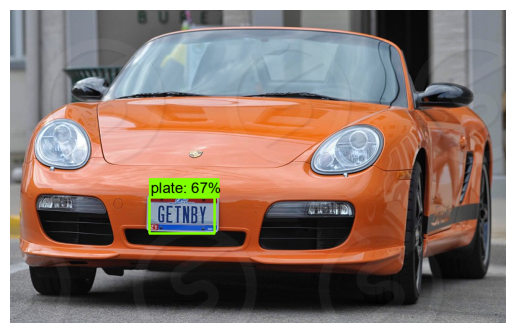

In [48]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import cv2
import pytesseract
import re

warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
#IMAGE_DIRECTORY = 'C:\\Users\\georg\\OneDrive\\Desktop\\TensorFlow\\workspace\\training_demo\\images\\actual_test\\'
#IMAGE_PATHS = [os.path.join(IMAGE_DIRECTORY, filename) for filename in os.listdir(IMAGE_DIRECTORY) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))]
IMAGE_PATHS = ['C:\\Users\\georg\\OneDrive\\Desktop\\TensorFlow\\workspace\\training_demo\\images\\actual_test\\GETNBY.jpg']

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

total_characters = 0
num_matches = 0
for image_path in IMAGE_PATHS:

    filename = os.path.basename(image_path)

    image_np = load_image_into_numpy_array(image_path)
    image_h, image_w, _ = image_np.shape

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=1,
          min_score_thresh=.30,
          agnostic_mode=False)

    bboxes = detections['detection_boxes']
    scores = detections['detection_scores']
    classes = detections['detection_classes']
    num_detections = detections['num_detections']

    # Filter out the boxes with scores above the minimum threshold (0.30 in this case)
    score_threshold = 0.30
    filtered_indices = scores >= score_threshold
    filtered_scores = scores[filtered_indices]
    filtered_bboxes = bboxes[filtered_indices]

    # Find the index of the bounding box with the highest score
    highest_score_index = np.argmax(filtered_scores)

    # Get the highest scoring bounding box and its class
    highest_score_bbox = filtered_bboxes[highest_score_index]
    highest_score_class = int(classes[filtered_indices][highest_score_index])

    # Convert normalized bounding box to original image coordinates
    original_h, original_w, _ = image_np.shape
    bbox = highest_score_bbox * [original_h, original_w, original_h, original_w]

    # Convert the bounding box and score to lists
    bbox = bbox.tolist()
    score = float(filtered_scores[highest_score_index])

    height_ratio = int(image_h / 25)
    print('Running inference for {}... '.format(filename), end='')

    plate_number = recognize_plate(image_np, bbox)
  #  cv2.putText(image_np_with_detections, plate_number, (int(bbox[1]), int(bbox[0]-height_ratio)), 
   #     cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,0), 2)
    
    actual_plate = filename.split('.')[0]
    num_matches2=0
    if len(actual_plate) == len(plate_number):
        total_characters += len(actual_plate)
        for a, p in zip(actual_plate, plate_number):
            if a == p:
                num_matches += 1
                num_matches2+=1
        print(round(100*num_matches2/len(actual_plate),2),"%")
  
    plt.axis('off')
    plt.imshow(image_np_with_detections)
    print('Done')
if total_characters!=0:
  print(round((num_matches/total_characters)*100,2))
